In [31]:
import time, re
import pandas as pd

from urllib.parse import urlparse, parse_qs
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

In [32]:
# function to generate URLs for different pages
def generate_page_url(base_url, query_params, page):
    query_params['page'] = str(page)
    return base_url + '?' + '&'.join([f"{key}={value}" for key, value in query_params.items()])

# function to generate URLs for every products
def extract_params_url(url):
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    return query_params['r'][0]

# function to extract the webpage
def extract_webpage(keyword, n_pages):
    
    # place to store the data
    data = []
    
    # webdriver configuration
    options = webdriver.ChromeOptions() 
    options.add_argument("start-maximized")
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    driver = webdriver.Chrome(service = ChromeService(ChromeDriverManager().install())) 
    
    # base url
    base_url = 'https://www.tokopedia.com/search'
    query_params = {
        'st': '',
        'q': keyword,
        'srp_component_id': '02.01.00.00',
        'srp_page_id': '',
        'srp_page_title': '',
        'navsource': ''
    }
    
    # looping in pages
    for page in range(1, n_pages + 1):
        url = generate_page_url(base_url, query_params, page)
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '#zeus-root')))
        time.sleep(2)

        # Parse the page
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Scrap website pages
        for item in soup.find_all('div', class_='css-1asz3by'):

            # product url
            link = item.find('a', class_ = 'pcv3__info-content css-gwkf0u')['href']
            if link.startswith("https://ta.tokopedia.com/"):    
                link = extract_params_url(link)

            # scrape website page
            driver.get(link)
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '#zeus-root')))
            time.sleep(2)

            # Parse the page
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            for product_item in soup.find_all('div', class_ = 'css-jmbq56'):

                # product name
                product_name = product_item.find('h1', class_ = 'css-1os9jjn').text

                # price
                price = product_item.find('div', class_ = 'price').text
                

                # sold amount
                try:
                    sold_amount_section = product_item.find_all('div', class_ = 'css-bczdt6')
                    if len(sold_amount_section) > 0:
                        for sold in sold_amount_section:
                            sold_amount = sold.find('p', class_ = 'css-vni7t6-unf-heading e1qvo2ff8').text
                    else:
                        sold_amount = '-'

                except AttributeError:
                    sold_amount = '-'

            # breadcrumbs
            breadcrumbs = soup.find_all('li', class_ = 'css-d5bnys')
            if len(breadcrumbs) > 0:
                c_1 = breadcrumbs[1].text
                c_2 = breadcrumbs[2].text
                c_3 = breadcrumbs[3].text

            # location
            try:
                location = soup.find_all('div', class_ = 'css-1pv3cmv pad-bottom')
                for loc in location:
                    city = loc.find('h2', class_ = 'css-1pd07ge-unf-heading e1qvo2ff2').b.text

            except AttributeError:
                location = soup.find_all('div', class_ = 'css-k008qs')
                for loc in location:
                    city = loc.find('h2', class_ = 'css-1wdzqxj-unf-heading e1qvo2ff2').text

            # seller
            seller = soup.find_all('div', class_ = 'css-k008qs')
            for store in seller:
                seller_name = store.find('h2', class_ = 'css-1wdzqxj-unf-heading e1qvo2ff2').text

            # description
            try:
                desc_section = soup.find('div', class_='css-16inwn4')
                if 'Lihat Selengkapnya' in desc_section.text:
                    action = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Lihat Selengkapnya")]')))
                    ActionChains(driver).move_to_element(action).perform()
                    action.click()
                    time.sleep(1)  # Adjust this sleep time as needed
                    soup_desc = BeautifulSoup(driver.page_source, 'html.parser')  # Update soup after clicking
                    desc_section = soup_desc.find('div', class_='css-16inwn4')
                    desc = desc_section.find('span', class_ = 'css-168ydy0 eytdjj01').text.strip()

                if '\xa0' in desc:
                    desc = desc.replace('\xa0', ' ')

            except AttributeError:
                desc_section = soup.find_all('div', class_='css-16inwn4')

                if len(desc_section) > 0:
                    desc = desc_section[0].find('span', class_='css-17zm3l eytdjj01').text.strip()
                    if 'Lihat Selengkapnya' in desc_section.text:
                        action = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "Lihat Selengkapnya")]')))
                        ActionChains(driver).move_to_element(action).perform()
                        action.click()
                        time.sleep(1)  # Adjust this sleep time as needed
                        soup_desc = BeautifulSoup(driver.page_source, 'html.parser')  # Update soup after clicking
                        desc_section = soup_desc.find('div', class_='css-16inwn4')
                        desc = desc_section.find('span', class_ = 'css-17zm3l eytdjj01').text.strip()

                if '\xa0' in desc:
                    desc = desc.replace('\xa0', ' ')
                    
                else:
                    desc = '-'

            # append all variables
            data.append(
                {
                    'Produk': product_name,
                    'C1': c_1,
                    'C2': c_2,
                    'C3': c_3,
                    'Terjual': sold_amount,
                    'Harga': price,
                    'Toko': seller_name,
                    'Kota Pengiriman': city,
                    'Created At': datetime.strftime(datetime.today(), '%Y-%m-%d %H:%M:%S'),
                    'Keyword': keyword,
                    'Deskripsi': desc
                }
            )

        time.sleep(1)

    # close driver
    driver.close()
    
    return data

**Celana Pria**

In [35]:
# run the function
data = extract_webpage(keyword = 'Celana Pendek Pria', n_pages = 10)

# dataframe
df = pd.DataFrame(data)
df = df.drop_duplicates(subset = 'Produk').reset_index(drop = True)

# 'Terjual' adjustment
terjual = []
for i in df['Terjual']:
    if i != '-':
        number = re.search(r'\d+', i).group()
        if 'rb' in i:
            number = int(number + '000')
        
    else:
        number = 0
    terjual.append(number)
    
df['terjual_new'] = terjual
df['terjual_new'].value_counts()

# view
df

TimeoutException: Message: timeout: Timed out receiving message from renderer: -0.000
  (Session info: chrome=123.0.6312.106)
Stacktrace:
	GetHandleVerifier [0x00D14CA3+225091]
	(No symbol) [0x00C44DF1]
	(No symbol) [0x00AE9A7A]
	(No symbol) [0x00ADAEC1]
	(No symbol) [0x00ADACF3]
	(No symbol) [0x00AD93C3]
	(No symbol) [0x00AD9B3D]
	(No symbol) [0x00AE486A]
	(No symbol) [0x00AF2AD1]
	(No symbol) [0x00AF62E6]
	(No symbol) [0x00AD9F84]
	(No symbol) [0x00AF296F]
	(No symbol) [0x00B55BCF]
	(No symbol) [0x00B3F2F6]
	(No symbol) [0x00B179B9]
	(No symbol) [0x00B1879D]
	sqlite3_dbdata_init [0x01189A43+4064547]
	sqlite3_dbdata_init [0x0119104A+4094762]
	sqlite3_dbdata_init [0x0118B948+4072488]
	sqlite3_dbdata_init [0x00E8C9A9+930953]
	(No symbol) [0x00C507C4]
	(No symbol) [0x00C4ACE8]
	(No symbol) [0x00C4AE11]
	(No symbol) [0x00C3CA80]
	BaseThreadInitThunk [0x76598494+36]
	RtlAreBitsSet [0x77D941C8+136]
	RtlAreBitsSet [0x77D94198+88]


**Sepatu Adidas Air Max**

In [282]:
# run the function
data = extract_webpage(keyword = 'Sepatu Adidas Air Max', n_pages = 1)

# dataframe
df_1 = pd.DataFrame(data)
df_1 = df_1.drop_duplicates(subset = 'Produk').reset_index(drop = True)

# 'Terjual' adjustment
terjual = []
for i in df_1['Terjual']:
    if i != '-':
        number = re.search(r'\d+', i).group()
        if 'rb' in i:
            number = int(number + '000')
        
    else:
        number = 0
    terjual.append(number)
    
df_1['terjual_new'] = terjual
df_1['terjual_new'].value_counts()

df_1

,Produk,C1,C2,C3,Terjual,Harga,Toko,Kota Pengiriman,Created At,Keyword,Deskripsi
0,Nike Air Max 1 SC Dark Stucco Original Resmi B...,Fashion Pria,Sepatu Pria,Sneakers Pria,Terjual 2,Rp2.899.000,Will Goods,Jakarta Selatan,,Sepatu Adidas Air Max,nike air max 1 sc dark stuccofor menready limi...
1,Nike Air Max Plus Black White Original Resmi B...,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp3.299.000,Will Goods,Jakarta Selatan,,Sepatu Adidas Air Max,Nike Air Max Plus Black Whitefor menready limi...
2,Nike Air Max Flyknit Racer Black Anthrachite O...,Fashion Pria,Sepatu Pria,Sneakers Pria,Terjual 2,Rp3.099.000,Will Goods,Jakarta Selatan,,Sepatu Adidas Air Max,nike air max flyknit blackfor menready limited...
3,Sepatu Adidas NMD R1 original SALE READY boost...,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp1.199.000,Kellyn Shop,Jakarta Barat,,Sepatu Adidas Air Max,"Ready size 44 2/3 / UK 10 / US 10,5"
4,Sepatu Puma X First Mile Erupt Trail adidas ul...,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp1.099.000,Kellyn Shop,Jakarta Barat,,Sepatu Adidas Air Max,Sepatu Puma X First Mile Erupt TrailSize EU 43...
5,Sepatu Adidas NMD V3 Original SALE READY Nike ...,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp1.299.000,Kellyn Shop,Jakarta Barat,,Sepatu Adidas Air Max,"Ready Size UK 7, 40 2/3"
6,SEPATU SEKOLAH KETS ADIDAS AIR MAX TABUNG HITA...,Fashion Pria,Sepatu Pria,Sneakers Pria,Terjual 5,Rp143.900,MILY Arto SHOP,Jakarta Pusat,,Sepatu Adidas Air Max,"WELCOMEBarang toko Kami READY STOCK, bisa lang..."
7,sepatu adidas air max,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp1.280.000,warung pa dadang,Kota Surabaya,,Sepatu Adidas Air Max,ready stok yaa barang original 100% silahkan d...
8,Sepatu Sekolah Kets Adidas Air Max Tabung Hitam,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp213.000,rendrar shhii,Jakarta Selatan,,Sepatu Adidas Air Max,WELCOMECocok untuk pria/wanita dipakai sekolah...
9,H✉75 Sepatu Sekolah Kets Adidas Air Max Hitam ...,Fashion Pria,Sepatu Pria,Sneakers Pria,-,Rp231.000,wasfiyatuleshop,Jakarta Pusat,,Sepatu Adidas Air Max,* Penting untuk dipahami dan mengerti JUDUL da...


**Merge DataFrames**

In [276]:
df_merge = pd.concat([df, df_1])
df_merge.to_csv('C:/Users/User/Documents/Tokopedia Web Scrapping.csv', index = False)

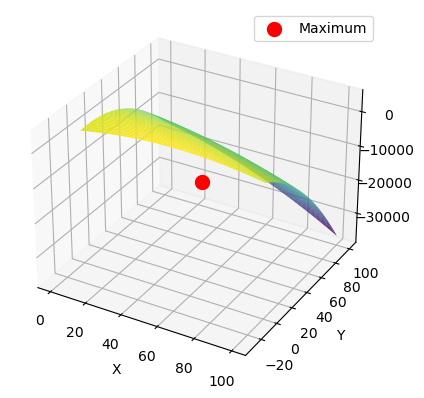

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return 100*x - x**2 - 2*x*y - 2*y**2 + 40*y

# Generate x and y values
x = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Plot the critical point
ax.scatter(80, -30, f(80, -30), color='red', s=100, label='Maximum')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('f(X, Y)')
# ax.set_title('Surface Plot of f(X, Y)')

# Add a legend
ax.legend()

plt.show()